# Compiling Unitaries Using Diffusion Models

This notebook is based on the work presented in [Quantum circuit synthesis with diffusion models, Florian Fürrutter, Gorka Muñoz-Gil & Hans J. Briegel , Nat. Mach. Intell. **6**, 515–524 (2024)](https://doi.org/10.1038/s42256-024-00831-9).

Quantum computing relies on efficiently translating quantum operations into viable physical realizations on existing quantum hardware. Recently, diffusion models — a powerful class of generative models in machine learning — have demonstrated exceptional performance on this task. 

In this tutorial notebook, we will demonstrate how to use this method to synthesize arbitrary unitaries into a `cudaq.kernel`, effectively decomposing them into sequences of quantum gates, a process commonly known as unitary compilation.

Our focus will be on generating circuits using a pre-trained model. Specifically, we will illustrate how to compile 3-qubit unitaries.

### Diffusion model pipeline

Generative diffusion models (DMs) have recently delivered remarkable results across a wide range of applications, from image generation to protein folding. In this work, we leverage DMs to generate quantum circuits based on a user specified unitary matrix and a text prompt that defines the allowed gate set, effectively using DMs as unitary compilers. The method is thoroughly explained in Ref. [(Fürrutter et al., 2024)](https://doi.org/10.1038/s42256-024-00831-9). The following figure  provides an overview of the proposed circuit generation pipeline:

<figure>
  <img src="images/pipeline_simplified.png" alt="Quantum circuit generation pipeline overview" width="70%"/>
  <figcaption><b>Quantum circuit generation pipeline</b>. Figure adapted from <a href="https://doi.org/10.1038/s42256-024-00831-9">(Fürrutter et al., 2024)</a></figcaption>
</figure>

The pipeline consists on 3 main components:

**1) Circuit encoding:** Like any neural network, diffusion models operate with continuous inputs and outputs. However, since the circuits we consider are composed of discrete gates (i.e., with no continuous parameters), we develop a mapping that transforms each gate into a continuous vector. This allows us to represent a given circuit as a three-dimensional tensor, as illustrated. Crucially, this mapping is invertible: when the DM generates continuous tensors, we can apply the inverse map to convert them back into the circuit form. An overview of these steps is provided in the figure below:

<figure>
  <img src="images/circuit_encoding.png" alt="Quantum circuit encoding" width="60%"/>
  <figcaption><b>Quantum circuit encoding</b>. Figure adapted from <a href="https://doi.org/10.1038/s42256-024-00831-9">(Fürrutter et al., 2024)</a></figcaption>
</figure>

**2) Conditioning:** The user's input (the set of available gates and the unitary to compile) is also transformed into a continuous tensor by two neural networks. For the gate set description, where the input is a text prompt (e.g., "Compile using ['x', 'h']"), we utilize a pre-trained language model. For the unitary, we employ a neural network that is training jointly with the diffusion model.

**3) Unitary compilation:** The generation procedure follows the typical DM process: the model is given a fully noisy tensor which is iteratively de-noised until reaching a clean sample based on the given conditioning (the desired unitary and gate set). The tensors generated by the DM are then mapped to circuits via the inverse encoding procedure. To learn more about the practical implementation of diffusion models we recommend [this tutorial](https://course.fast.ai/Lessons/lesson9.html). 

In the following we will use `CUDA-Q` and `genQC` to perform all these steps and go from a desired unitary matrix, $U$, to a quantum circuit that we can execute using CUDA-Q. 

### Setup and compilation

In [24]:
!pip install genQC==0.1.0 -q

In [25]:
import genQC
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.inference.export_cudaq import genqc_to_cudaq
import genQC.inference.infer_compilation as infer_comp
import genQC.util as util

import numpy as np
import torch

# Fixed seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [26]:
device = util.infer_torch_device()  # Use CUDA if we can
util.MemoryCleaner.purge_mem()  # Clean existing memory allocation
print(device)

[INFO]: Cuda device has a capability of 8.0 (>= 8), allowing tf32 matmul.
cuda


### Load model

First, we load the pre-trained model weights and setup the DM pipeline.




In [27]:
pipeline = DiffusionPipeline.from_pretrained(
    "Floki00/qc_unitary_3qubit", device)  # Download from Hugging Face
pipeline.scheduler.set_timesteps(40)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cuda.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.


Set parameters the model was trained on. Note that these are fixed and depend on the pre-trained model.

In [28]:
vocab = {
    i + 1: gate for i, gate in enumerate(pipeline.gate_pool)
}  # Gateset used during training, used for decoding
num_of_qubits = 3  # Number of qubits
max_gates = 12  # Maximum number of gates

### Unitary compilation

Let's start by defining the unitary we want to compile. Note that this model has been trained to compile unitaries that arise from circuits composed of the gates contain in `vocab`. While this is a universal gate set (i.e. can perform universal computation), it can only do so with an infinite number of gates. Because the number of gates in the model is restricted to 12, we can only expect the model to generate unitaries under this constraints. We will consider here the compilation of one of such unitary. Nonetheless, stay tuned for bigger and better models!

We start by defining our unitary as a `numpy.matrix`:

In [29]:
U = np.matrix([[0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., -0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [-0.70710678, 0., 0., 0., 0.70710678, 0., 0., 0.],
               [0., 0.70710678, 0., 0., 0., -0.70710678, 0., 0.],
               [0., 0., 0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., 0.70710678, 0., 0., 0.70710678, 0.],
               [0., 0., -0.70710678, 0., 0., 0., 0., 0.70710678],
               [0., 0., 0., -0.70710678, 0., 0., 0.70710678, 0.]],
              dtype=np.complex128)

and check that the matrix is indeed unitary, i.e. $U^{\dagger} U = U U^{\dagger} = I$

In [30]:
assert np.allclose(U.H @ U, np.identity(2**num_of_qubits)) and np.allclose(
    U @ U.H, np.identity(2**num_of_qubits))  #check if unitary

The loaded model was trained on the gate set `['h', 'cx', 'z', 'x', 'ccx', 'swap']`. Specifically, it was trained to generate circuits using any arbitrary subset of this gate set. Therefore, during inference, we can instruct the model to compile the unitary using any of these subsets. However, it is crucial to follow the prompt structure `Compile using [...]`, as the model was trained with this specific format. For example, let's consider a scenario where we compile the unitary without using the `x` gate:

In [31]:
# Notice how the x gate missing from the prompt since this is a restriction we set
prompt = "Compile using: ['h', 'cx', 'z', 'ccx', 'swap']"

Now, we call the diffusion model pipeline to generate encoded circuits based on the specified conditions: `prompt` and `U`. One of the key advantages of this method is that, once the model is trained, sampling new circuits is very fast. Therefore, under the same conditions defined above, we will generate 128 circuits and analyze them in the following sections.

In [32]:
# Number of circuits to sample from the trained DM.
samples = 128

# As the neural network works only with real numbers, we first separate
# the two components and create a 2 dimensional tensor for the magnitude
# of each component:
U_r, U_i = torch.Tensor(np.real(U)), torch.Tensor(np.imag(U))
U_tensor = torch.stack([U_r, U_i], dim=0)

# Now we generate a tensor representation of the desired quantum circuit using the DM based on the prompt and U. This is also known as inference.
out_tensors = infer_comp.generate_comp_tensors(
    pipeline=pipeline,
    prompt=prompt,
    U=U_tensor,
    samples=samples,
    system_size=
    num_of_qubits,  # Max qubit number allowed by the model (this model is only trained with 3 qubits)
    num_of_qubits=num_of_qubits,
    max_gates=max_gates,
    g=10  # classifier-free-guidance (CFG) scale
)

Below is an example of a generated tensor which represents a quantum circuit: 

In [33]:
out_tensors[0]

tensor([[ 5,  3,  0,  0, -5,  3,  3,  0, -5,  0,  0,  0],
        [-5,  0,  0,  6,  5,  0,  0,  3,  5,  0,  0,  0],
        [-5,  0,  1,  6, -5,  0,  0,  0, -5,  0,  0,  0]])

### Convert tensors to CUDA-Q

Next, we convert the generated tensors into `cudaq.kernels`.

In [34]:
import cudaq

cudaq.set_target('qpp-cpu')  # Note that cpu is faster for 3 qubit kernels

# cudaq.set_target('nvidia') # Set to GPU for larger circuits

In [35]:
kernel_list = []
valid_tensors = []

invalid_tensors = 0
for out_tensors_i in tqdm(out_tensors):

    # Use a try-except to catch invalid tensors (if any)
    try:
        kernel = genqc_to_cudaq(out_tensors_i,
                                vocab)  # Convert out_tensors to CUDA-Q kernels
    except:
        kernel = None

    if kernel:
        kernel_list.append(kernel)
        valid_tensors.append(out_tensors_i)
    else:
        invalid_tensors += 1

print(
    f"The model generated {invalid_tensors} invalid tensors that does not correspond to circuits."
)

  0%|          | 0/128 [00:00<?, ?it/s]

The model generated 1 invalid tensors that does not correspond to circuits.


For example, the following tensor encoding

In [36]:
valid_tensors[0]

tensor([[ 5,  3,  0,  0, -5,  3,  3,  0, -5,  0,  0,  0],
        [-5,  0,  0,  6,  5,  0,  0,  3,  5,  0,  0,  0],
        [-5,  0,  1,  6, -5,  0,  0,  0, -5,  0,  0,  0]])

corresponds to the following `cudaq.kernel`

In [37]:
# Arbitrary input state to the circuit for plotting

input_state = [0] * (2**num_of_qubits)

print(cudaq.draw(kernel_list[0], input_state))

     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       



### Evaluate generated circuits

As mentioned earlier, one of the key advantages of using diffusion models (DMs) as a unitary compiler is the ability to rapidly sample many circuits. However, as is common in machine learning, the model has a certain accuracy, meaning not all generated circuits are expected to exactly compile the specified unitary. In this section, we will evaluate how many of the generated circuits are indeed correct and then perform post-selection to identify (at least) one circuit that successfully performs the desired unitary operation.

### Simulate kernels

First, we calculate the unitary matrix $U$ implemented by each of the kernels. The elements of this matrix are defined by the transition amplitudes between the basis states, which can be expressed as:
$$
\begin{equation}
   \langle i|kernel|j\rangle = U_{ij},
\end{equation}
$$
where $|i\rangle$ and $|j\rangle$ are computational basis states (typically in the $z$-basis), with $|n\rangle$ representing the standard basis vector that has a 1 in the $n$-th position and 0 elsewhere.

In [38]:
N = 2**num_of_qubits

got_unitaries = np.zeros((len(kernel_list), N, N), dtype=np.complex128)

for i, kernel in tqdm(enumerate(kernel_list), total=got_unitaries.shape[0]):
    for j in range(N):
        basis_state_j = np.zeros((N), dtype=np.complex128)
        basis_state_j[j] = 1

        got_unitaries[i, :,
                      j] = np.array(cudaq.get_state(kernel, basis_state_j),
                                    copy=False)

  0%|          | 0/127 [00:00<?, ?it/s]

For example, the circuit printed above corresponds to the following unitary:

In [ ]:
np.set_printoptions(linewidth=1000)
print(np.round(got_unitaries[0], 4))

[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]]


### Compare unitaries

Now that we have the unitaries for each of the kernels, we compare them to the user provided unitary matrix, `U`. To do so, we compute the infidelity between the exact unitary and the generated ones. The infidelity is a value between 0 and 1, where 0 indicates that the unitaries are identical (up to a global phase).

In [ ]:
def infidelity(want_unitary, got_unitary):
    return 1 - np.abs(
        np.trace(np.conj(want_unitary).T @ got_unitary) / 2**num_of_qubits)**2


infidelities = np.array(
    [infidelity(U, got_unitary) for got_unitary in got_unitaries])

Let's now plot an histogram of the infidelities for our generated circuits:

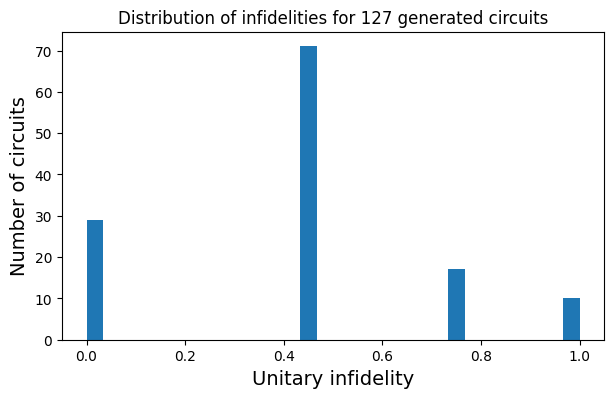

In [ ]:
plt.figure(figsize=(7, 4))
plt.title(
    f"Distribution of infidelities for {len(got_unitaries)} generated circuits",
    fontsize=12)
plt.ylabel("Number of circuits", fontsize=14)
plt.xlabel("Unitary infidelity", fontsize=14)
plt.hist(infidelities, bins=30)
plt.show()

As we can see, the model generated almost 30 circuits that compile the unitary with an infidelity close or equal to zero! The kernel with the lowest infidelity is:

In [ ]:
min_index = np.argmin(infidelities)

print(f"The best kernel has an infidelity of {infidelities[min_index]:0.2},")

input_state = [0] * (2**num_of_qubits)
input_state[0] = 1
print(cudaq.draw(kernel_list[min_index], input_state))

print(f"with the unitary:")
print(np.round(got_unitaries[min_index], 4))

The best kernel has an infidelity of 3.4e-09,
     ╭───╮╭───╮        ╭───╮╭───╮     
q0 : ┤ x ├┤ z ├─────●──┤ z ├┤ z ├──●──
     ╰─┬─╯╰───╯   ╭─┴─╮├───┤╰───╯╭─┴─╮
q1 : ──●────────╳─┤ x ├┤ z ├─────┤ x ├
       │  ╭───╮ │ ╰─┬─╯╰───╯     ╰─┬─╯
q2 : ──●──┤ h ├─╳───●──────────────●──
          ╰───╯                       

with the unitary:
[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.   

which, as we can see, exactly compiled our wanted unitary:

In [ ]:
print(np.round(U, 4))

[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]]


### Choosing the circuit you need

As we have seen above, we now have almost 30 kernels that compile the desired unitary! This is particularly valuable when dealing with hardware constraints, where, for instance, we might want to avoid using certain qubits or specific gates. One practical example is finding the circuit with the fewest Toffoli gates (also known as `ccx`). In our `vocab` definition above, we identified that `ccx` corresponds to the label 5 in our tokenized tensors. Let's use this information to search for the circuit that minimizes the number of `ccx` gates:

In [ ]:
# First, we remove possible duplicates and only pick distinct circuits
_, idx_unique = np.unique(np.array(valid_tensors), axis=0, return_index=True)
unique_tensors = torch.stack(valid_tensors)[idx_unique]
unique_infidelities = infidelities[idx_unique]
unique_kernels = [kernel_list[idx] for idx in idx_unique]

# Then, find the correct circuits
idx_correct = torch.argwhere(torch.tensor(unique_infidelities) < 0.01).flatten()
correct_tensors = unique_tensors[idx_correct]
print(
    f"The model generated {correct_tensors.shape[0]} distinct correct circuits."
)

# Now let's flatten the last two dimensions (related to the actual circuit) and find out how many 5's (i.e. ccx) gates each circuit has:
num_ccx = (correct_tensors.flatten(1, 2) == 5).sum(1)
print("These circuits have this number of ccx gates:", num_ccx)

The model generated 17 distinct correct circuits.
These circuits have this number of ccx gates: tensor([1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1])


As we can see, it appears that the diffusion model (DM) requires at least one Toffoli gate to compile the unitary. We can now print a few of these circuits to select the one that best suits our needs, or to study whether there are any interesting patterns the model employs for this specific unitary.

In [ ]:
# Get the correct kernels
correct_kernels = [unique_kernels[idx] for idx in idx_correct]

# Get the ones with only one ccx
correct_kernels_ccx1 = [
    correct_kernels[idx] for idx in torch.argwhere(num_ccx == 1).flatten()
]

# Draw a few of this circuits
for kernel in correct_kernels_ccx1[:3]:
    print(cudaq.draw(kernel, input_state))

        ╭───╮╭───╮               
q0 : ───┤ x ├┤ z ├───────●───────
        ╰─┬─╯├───┤╭───╮  │       
q1 : ─╳───●──┤ h ├┤ z ├──┼───────
      │   │  ├───┤╰───╯╭─┴─╮╭───╮
q2 : ─╳───●──┤ h ├─────┤ x ├┤ h ├
             ╰───╯     ╰───╯╰───╯

     ╭───╮╭───╮             
q0 : ┤ x ├┤ z ├──●──────────
     ╰─┬─╯├───┤╭─┴─╮        
q1 : ──●──┤ h ├┤ x ├─╳──────
       │  ├───┤├───┤ │ ╭───╮
q2 : ──●──┤ h ├┤ z ├─╳─┤ h ├
          ╰───╯╰───╯   ╰───╯

     ╭───╮╭───╮             
q0 : ┤ x ├┤ z ├──●──────────
     ╰─┬─╯├───┤╭─┴─╮        
q1 : ──●──┤ h ├┤ x ├─╳──────
       │  ├───┤├───┤ │ ╭───╮
q2 : ──●──┤ h ├┤ z ├─╳─┤ h ├
          ╰───╯╰───╯   ╰───╯



In [ ]:
print(cudaq.__version__)
print("genQC Version", genQC.__version__)

CUDA-Q Version latest (https://github.com/NVIDIA/cuda-quantum a1ee37087fbd5c14a31d5de3441f92432d0dca68)
genQC Version 0.1.0
